In [1]:
backWidth = 400.0
backHeight = 400.0
annotation_train_path = './train/annotations'
annotation_validation_path = './val/annotations'

In [2]:
def _load_image_data(path, grayscale=True):
    
    from keras.preprocessing.image import load_img
    from keras.preprocessing.image import img_to_array
    import numpy as np

    input_img = load_img(path, grayscale)
    img_data = img_to_array(input_img)
    #print('data: ', img_data, 'size: ', input_img.size)
    return img_data, input_img.size


In [3]:
def _show_image(img_data, box, dim):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import numpy as np
    
    #plt.imshow(np.uint8(img_data))
    #plt.show()
    
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(np.uint8(img_data))

    # Create a Rectangle patch around the card image
    rect = patches.Rectangle((box[0]*dim[0],box[1]*dim[1]),(box[2]-box[0])*dim[0],(box[3]-box[1])*dim[1],linewidth=1,edgecolor='r',facecolor='none')
    
    #Plot a solid rectangle dot
    #rect = patches.Rectangle((box[0]*dim[0],box[1]*dim[1]),0.02*dim[0],0.02*dim[1],linewidth=1,edgecolor='r',color='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.show()

In [4]:
def _load_image_data_label(path, scale = False):
    import xml.etree.ElementTree as ET
    
    tree = ET.parse(path)
    root = tree.getroot()

    #load image binary
    pathImage = root.find('path').text
    #print("image path:", pathImage)
    img_data, dim = _load_image_data(pathImage)
    if scale == True: 
        img_data = _scale_image_data(img_data)

    xmin = float(root.find('xmin').text) / dim[0]
    ymin = float(root.find('ymin').text) / dim[1]
    
    #Comment out the following 2 lines to return only the left/top coordinate
    xmax = float(root.find('xmax').text) / dim[0]
    ymax = float(root.find('ymax').text) / dim[1]
    
    #return both image binary and label
    #print('label', [xmin, ymin, xmax, ymax])
    #un-Comment out to return left/top coordinate only
    #return img_data, [xmin, ymin], dim
    return img_data, [xmin, ymin, xmax, ymax], dim

In [5]:
def _scale_image_data(img_data):
    img_data = img_data.astype('float32')
    img_data /= 255
    return img_data

In [6]:
def _show_image_path(annotation_path, index, new_labels = None):
    path = '{0}/{1}.xml'.format(annotation_path, '{:06d}'.format(index))
    features_noscale,load_labels,dim = _load_image_data_label(path)
    if new_labels is not None:
        labels = new_labels
    else:
        labels = load_labels
    #print('features: ', features_noscale, 'labels: ', labels, 'dim: ', dim)
    _show_image(features_noscale, labels, dim) 

In [7]:
def predict_imgPath(path): 
    import numpy as np
        
    img,size = _load_image_data(path)
    img_scaled = _scale_image_data(img)
    image_batch = np.expand_dims(img_scaled, axis=0)
    pre_labels = model.predict(image_batch, batch_size=1)
    return pre_labels, img, size

In [8]:
def predict_xmlPath(annotation_path,index):
    from numpy import random
    import numpy as np
    import xml.etree.ElementTree as ET

    path = '{0}/{1}.xml'.format(annotation_path, '{:06d}'.format(index))
    tree = ET.parse(path)
    root = tree.getroot()
    path = root.find('path').text

    return predict_imgPath(path)

In [9]:
from keras.models import load_model
model = load_model('sunny_card_model_more_scale.h5')
model.summary()

/Users/atk847/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 400, 400, 24)      624       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 200, 200, 24)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 196, 196, 36)      21636     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 98, 98, 36)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 94, 94, 48)        43248     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 47, 47, 48)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 45, 45, 64)        27712     
__________

size:  3024
resizing
image shape: (400, 400, 1)


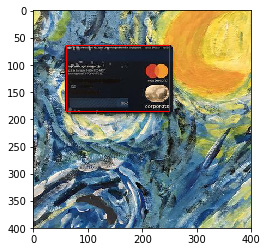

labels:  [ 59.806408  63.907516 249.27313  185.22812 ]


In [13]:
from keras.preprocessing.image import load_img
from PIL import Image, ImageDraw, ImageFilter

#path = "./input_data/GeneratedData_Train/000244.png"
imageExtension = ".jpg"
imagePath = "./realcards/IMG_5041"
path = imagePath + imageExtension

img = Image.open(path)
print ('size: ', img.size[0])
if img.size[0] > 400.0:
    print('resizing')
    img = img.resize((400,400), Image.ANTIALIAS)
    path = imagePath + 't' + imageExtension
    img.save(path)

origImg, dim = _load_image_data(path, False)
labels, img, dim = predict_imgPath(path)
print('image shape:', img.shape)
_show_image(origImg, labels[0], dim) 
print('labels: ', labels[0] * 400)

In [212]:
import coremltools
model.save('sunny_card_model.h5')
coreml_model = coremltools.converters.keras.convert('sunny_card_model.h5', input_names=['image'], image_input_names=['image'], output_names=['output'], image_scale=1/255.0)
coreml_model.save('sunny_card_model_gray.mlmodel')

0 : conv2d_32_input, <keras.engine.topology.InputLayer object at 0xd7b86c4e0>
1 : conv2d_32, <keras.layers.convolutional.Conv2D object at 0xd7b86c4a8>
2 : conv2d_32__activation__, <keras.layers.core.Activation object at 0xd7baf1860>
3 : max_pooling2d_32, <keras.layers.pooling.MaxPooling2D object at 0xd7b86c710>
4 : conv2d_33, <keras.layers.convolutional.Conv2D object at 0xd7b87ad68>
5 : conv2d_33__activation__, <keras.layers.core.Activation object at 0xd7baf1400>
6 : max_pooling2d_33, <keras.layers.pooling.MaxPooling2D object at 0xd7b8925c0>
7 : conv2d_34, <keras.layers.convolutional.Conv2D object at 0xd7aa63400>
8 : conv2d_34__activation__, <keras.layers.core.Activation object at 0xb39685be0>
9 : max_pooling2d_34, <keras.layers.pooling.MaxPooling2D object at 0xd7aa7d208>
10 : conv2d_35, <keras.layers.convolutional.Conv2D object at 0xd7aa96400>
11 : conv2d_35__activation__, <keras.layers.core.Activation object at 0xb38f92f98>
12 : max_pooling2d_35, <keras.layers.pooling.MaxPooling2D ob